In [ ]:
colab = False

if colab:
    !git clone https://github.com/janfb/pyro-meets-sbi.git
    %cd pyro-meets-sbi

    !uv pip install .

# SBI Cookie Factory: Pooled, Unpooled, and Hierarchical Models (Pyro + Neural Likelihoods)

In the Pyro notebook, we built pooled, unpooled, and hierarchical models for the cookie-chip factory using an analytical Poisson likelihood. In this notebook, we mirror those three approaches with Simulation-Based Inference (SBI): we replace the analytical likelihood with a neural likelihood estimator while retaining Pyro’s modeling structure.

What we do here
- Implement the same three models (pooled, unpooled, hierarchical) using SBI’s neural likelihood.
- Show parity with the Pyro results and discuss when SBI is beneficial (likelihood intractable).
- Keep the same cookie recipe inference task for a direct, apples-to-apples comparison.

Learning goals
- Understand how to swap analytical likelihoods for neural likelihoods (NLE) in Pyro.
- Preserve hierarchical structure and partial pooling with SBI-based likelihoods.
- Evaluate calibration and performance vs. the

In [ ]:
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from pyro.infer import MCMC, NUTS

# SBI imports
from sbi.inference import NLE
from sbi.neural_nets.net_builders.categorial import build_categoricalmassestimator
from sbi.utils.pyroutils import to_pyro_distribution

from utils import load_cookie_dataset

# Set up plotting style
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

# Set random seeds for reproducibility
torch.manual_seed(42)
pyro.set_rng_seed(42)
pyro.clear_param_store()

print(f"Pyro {pyro.__version__} | PyTorch {torch.__version__}")
print("SBI+Pyro integration ready! 🚀")

Pyro 1.9.1 | PyTorch 2.5.1
SBI+Pyro integration ready! 🚀


## Data: Cookie Chip Counts

Our dataset contains chocolate chip counts from cookies produced at 5 different factory locations. Each location follows the same global recipe but shows location-specific variation.

**The challenge**: How do we model both global patterns and local variations in a principled way?

In [2]:
cds = load_cookie_dataset()  # CookieDataset dataclass

cookies = cds.cookies
location_stats = cds.location_stats
locations = cds.locations
chips = cds.chips
n_locations = cds.n_locations
location_rates = cds.location_rates
sample_sizes = cds.sample_sizes

print(f"Loaded dataset: {len(cookies)} cookies from {n_locations} locations")
print(f"CSV path: {cds.path}")
print(location_stats)

Loaded dataset: 125 cookies from 5 locations
CSV path: /Users/janteusen/qode/pyro-meets-sbi/data/cookie_chips_data.csv
  location       mean       std  count
0        1   9.033333  3.614943     30
1        2   5.733333  2.715642     30
2        3  10.000000  2.982709     30
3        4   8.300000  2.781094     30
4        5   9.600000  4.560702      5


## Data Visualization

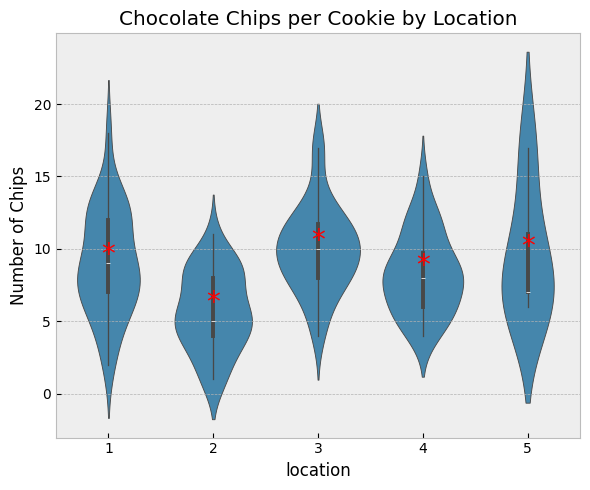

In [3]:
# Visualize the data structure
fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))

# Location-specific distributions
sns.violinplot(data=cookies, x="location", y="chips", ax=ax1)
ax1.set_title("Chocolate Chips per Cookie by Location")
ax1.set_ylabel("Number of Chips")

# Add true location rates as stars for each location
for i, rates in enumerate(location_rates):
    ax1.text(i, rates, "*", color="red", fontsize=20, ha="center")

plt.tight_layout()
plt.show()

# Key observation: Clear differences suggest hierarchical modeling

## SBI meets Pyro

**The Challenge**: What if we had a complex cookie production simulator instead of a simple Poisson model?

**The Solution**: Train a neural network to learn the likelihood p(chips|rate) from simulations, then use it in Pyro!

### Neural Likelihood Estimation (NLE) Workflow:
1. **Simulate**: Generate (rate, chip_count) pairs from our cookie model
2. **Train**: Neural network learns p(chip_count | rate)  
3. **Integrate**: Use trained estimator as a Pyro distribution
4. **Infer**: Apply to both pooled and hierarchical models

**Key insight**: The same neural likelihood works across different Pyro model structures!

In [4]:
# Generate training data for Neural Likelihood Estimation
torch.manual_seed(42)
num_simulations = 50_000

# Sample rate parameters from prior
prior_concentration = 2.0
prior_rate = 1 / 5
rate_prior = torch.distributions.Gamma(
    concentration=prior_concentration, rate=prior_rate
)
theta_train = rate_prior.sample((num_simulations,))

# Generate chip counts using Poisson likelihood
x_train = torch.distributions.Poisson(rate=theta_train).sample()

print(f"Training dataset: {num_simulations} simulations")
print(f"Rate range: {theta_train.min():.1f} - {theta_train.max():.1f}")
print(f"Chip count range: {x_train.min()} - {x_train.max()}")

Training dataset: 50000 simulations
Rate range: 0.0 - 67.9
Chip count range: 0.0 - 76.0


In [ ]:
# Custom density estimator for discrete chip counts
# NOTE: We are using a categorical mass estimator here because the MNLE approach assumes
# both discrete and continuous inputs, but we only have discrete inputs.
def custom_categorical_estimator_builder(
    batch_x, batch_y, z_score_x="none", z_score_y="independent", **kwargs
):
    """Custom builder for categorical mass estimator with explicit num_categories"""
    # Determine number of categories from global data range
    max_chips = int(batch_y.max().item())
    min_chips = int(batch_y.min().item())
    num_categories = torch.tensor([max_chips - min_chips + 2])

    return build_categoricalmassestimator(
        batch_x=batch_x,
        batch_y=batch_y,
        z_score_x=z_score_x,
        z_score_y=z_score_y,
        num_categories=num_categories,
        num_hidden=100,  # Choose relatively tall layers because of ~80 categories
        num_layers=2,
        **kwargs,
    )


# Train Neural Likelihood Estimator
nle = NLE(
    prior=rate_prior,
    density_estimator=custom_categorical_estimator_builder,
    show_progress_bars=True,
)

# Add training data and train
nle = nle.append_simulations(
    theta=theta_train.unsqueeze(-1),
    x=x_train.unsqueeze(-1),
    exclude_invalid_x=False,
)

print("Training neural likelihood estimator...")
likelihood_estimator = nle.train()

Training neural likelihood estimator...
 Neural network successfully converged after 62 epochs.

In [6]:
# Load pyro posteriors from file
import pickle

try:
    with open("../data/cookie_posteriors.pkl", "rb") as f:
        data = pickle.load(f)
except FileNotFoundError:
    raise FileNotFoundError("Posterior file not found. Please ensure the file exists.")

pooled_posterior = data["pooled"]
unpooled_posterior = data["unpooled"]
hierarchical_posterior = data["hierarchical"]

In [7]:
# SBI-Pyro Integration: Pooled Model
def sbi_pooled_model(locations, chips=None):
    """Pooled model using SBI neural likelihood"""
    # Same prior as before
    lam = pyro.sample("lam", dist.Gamma(concentration=2.0, rate=1 / 5))

    # Use neural likelihood instead of analytical Poisson
    with pyro.plate("data", size=len(locations)):
        sbi_dist = to_pyro_distribution(likelihood_estimator, lam.unsqueeze(-1))
        pyro.sample("obs", sbi_dist, obs=chips)

    return lam


# Run inference with SBI likelihood
pyro.clear_param_store()
nuts_kernel = NUTS(sbi_pooled_model, target_accept_prob=0.9)
mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=1000, num_chains=1)
mcmc.run(locations, chips)  # integer counts for SBI

sbi_pooled_posterior = mcmc.get_samples()
sbi_pooled_rate = sbi_pooled_posterior["lam"].mean()

print(
    f"✅ SBI Pooled model: λ = {sbi_pooled_rate:.3f} (Pyro: {pooled_posterior['lam'].mean():.3f})"
)

Sample: 100%|██████████| 3000/3000 [00:09, 321.76it/s, step size=7.13e-01, acc. prob=0.956]

✅ SBI Pooled model: λ = 8.329 (Pyro: 8.321)


In [8]:
def sbi_unpooled_model(locations, chips=None):
    """Unpooled model using SBI neural likelihood"""
    # Independent priors for each location
    with pyro.plate("location", n_locations):
        lam = pyro.sample("lam", dist.Gamma(concentration=2.0, rate=1 / 5))

    # Use neural likelihood instead of analytical Poisson
    rate = lam[locations]
    with pyro.plate("data", size=len(locations)):
        sbi_dist = to_pyro_distribution(likelihood_estimator, rate.unsqueeze(-1))
        pyro.sample("obs", sbi_dist, obs=chips)

    return lam


# run inference
pyro.clear_param_store()
nuts_kernel = NUTS(sbi_unpooled_model, target_accept_prob=0.9)
mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=1000, num_chains=1)
mcmc.run(locations, chips)  # integer counts for SBI

sbi_unpooled_posterior = mcmc.get_samples()
sbi_unpooled_rates = sbi_unpooled_posterior["lam"].mean(dim=0)

Sample: 100%|██████████| 3000/3000 [00:18, 158.31it/s, step size=6.28e-01, acc. prob=0.915]


In [9]:
# SBI-Pyro Integration: Hierarchical Model
def sbi_hierarchical_model(locations, chips=None):
    """Hierarchical model using SBI neural likelihood"""
    # Same hierarchical structure as before
    mu = pyro.sample("mu", dist.Gamma(concentration=2.0, rate=1 / 5))
    sigma = pyro.sample("sigma", dist.Exponential(rate=1.0))

    alpha = mu**2 / sigma**2
    beta = mu / sigma**2

    with pyro.plate("location", n_locations):
        lams = pyro.sample("lam", dist.Gamma(concentration=alpha, rate=beta))

    # Use neural likelihood
    rates = lams[locations]
    with pyro.plate("data", size=len(locations)):
        sbi_dist = to_pyro_distribution(likelihood_estimator, rates.unsqueeze(-1))
        pyro.sample("obs", sbi_dist, obs=chips)

    return lams


# Run inference with SBI likelihood (same neural network!)
pyro.clear_param_store()
nuts_kernel = NUTS(sbi_hierarchical_model, target_accept_prob=0.9)
mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=1000, num_chains=1)
mcmc.run(locations, chips)  # integer counts for SBI

sbi_hierarchical_posterior = mcmc.get_samples()
sbi_hierarchical_rates = sbi_hierarchical_posterior["lam"].mean(dim=0)

Sample: 100%|██████████| 3000/3000 [00:35, 85.58it/s, step size=3.97e-01, acc. prob=0.944] 


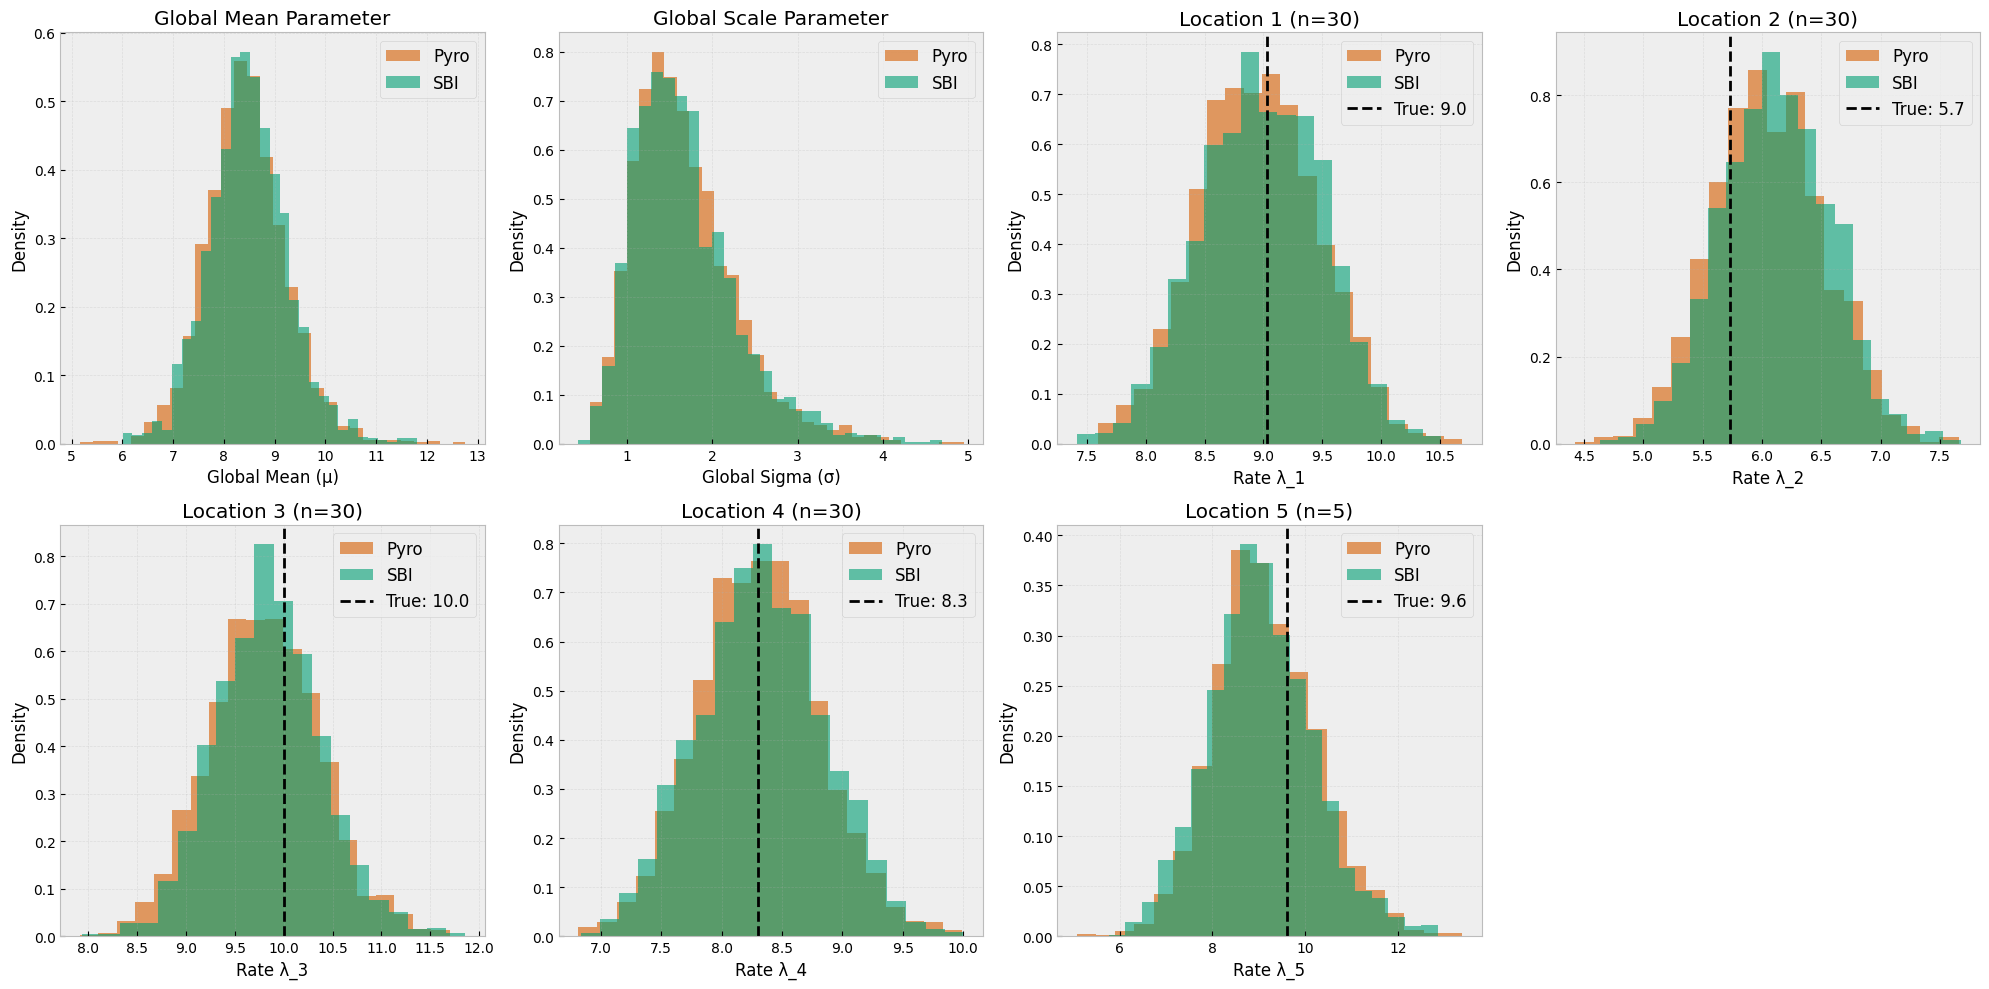

In [10]:
# Compare Pyro vs SBI Hierarchical Posteriors
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Define color scheme
pyro_color = "#D55E00"  # Orange-red for Pyro
sbi_color = "#009E73"  # Green for SBI

# Global parameters comparison (mu and sigma)
axes[0, 0].hist(
    hierarchical_posterior["mu"].numpy(),
    bins=30,
    alpha=0.6,
    density=True,
    color=pyro_color,
    label="Pyro",
)
axes[0, 0].hist(
    sbi_hierarchical_posterior["mu"].numpy(),
    bins=30,
    alpha=0.6,
    density=True,
    color=sbi_color,
    label="SBI",
)
axes[0, 0].set_xlabel("Global Mean (μ)")
axes[0, 0].set_ylabel("Density")
axes[0, 0].set_title("Global Mean Parameter")
axes[0, 0].legend(fontsize=12)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(
    hierarchical_posterior["sigma"].numpy(),
    bins=30,
    alpha=0.6,
    density=True,
    color=pyro_color,
    label="Pyro",
)
axes[0, 1].hist(
    sbi_hierarchical_posterior["sigma"].numpy(),
    bins=30,
    alpha=0.6,
    density=True,
    color=sbi_color,
    label="SBI",
)
axes[0, 1].set_xlabel("Global Sigma (σ)")
axes[0, 1].set_ylabel("Density")
axes[0, 1].set_title("Global Scale Parameter")
axes[0, 1].legend(fontsize=12)
axes[0, 1].grid(True, alpha=0.3)

# Location-specific rate parameters comparison
location_positions = [(0, 2), (0, 3), (1, 0), (1, 1), (1, 2)]

for i in range(n_locations):
    row, col = location_positions[i]

    axes[row, col].hist(
        hierarchical_posterior["lam"][:, i].numpy(),
        bins=20,
        alpha=0.6,
        density=True,
        color=pyro_color,
        label="Pyro",
    )
    axes[row, col].hist(
        sbi_hierarchical_posterior["lam"][:, i].numpy(),
        bins=20,
        alpha=0.6,
        density=True,
        color=sbi_color,
        label="SBI",
    )

    # Add true value line
    true_mean = location_rates[i]
    axes[row, col].axvline(
        true_mean,
        color="black",
        linestyle="--",
        linewidth=2,
        label=f"True: {true_mean:.1f}",
    )

    axes[row, col].set_xlabel(f"Rate λ_{i + 1}")
    axes[row, col].set_ylabel("Density")
    axes[row, col].set_title(f"Location {i + 1} (n={sample_sizes[i]})")
    axes[row, col].legend(fontsize=12)
    axes[row, col].grid(True, alpha=0.3)

# Remove unused subplot
axes[1, 3].remove()

plt.tight_layout()
plt.show()

## Summary: Same analysis as Pyro — now with SBI

### What we did

- Loaded the same cookie dataset used in the Pyro notebook.
- Trained a Neural Likelihood Estimator (NLE) on simulations of (rate → chip counts).
- Plugged the trained NLE into Pyro using the provided wrapper, without using the analytical Poisson.
- Ran the same models as before: pooled, unpooled, and hierarchical.
- Compared posteriors: the hierarchical model’s posterior distributions match the Pyro baseline closely.

### Key insights

- SBI lets us replace an analytical likelihood with a learned neural likelihood, while keeping Pyro’s modeling and MCMC workflow unchanged.
- A single trained NLE can be reused across pooled, unpooled, and hierarchical models—no retraining needed for each structure.
- Looking at the sampling speed and comparing the `sbi`-based vs. the `pyro` models we
  see that the `pyro`-based models are usually 1-3 times faster to sample.

### The big picture

SBI turns any simulator (as long as fast enough and not too high-D data or parameters)
into a Pyro-compatible likelihood, enabling hierarchical Bayesian inference when
analytical likelihoods are unavailable or impractical. Combining SBI with Pyro opens up:

- Complex physical simulations with hierarchical structure
- Agent-based models with group-level effects
- Cognitive models with individual differences
- Climate and geospatial models with spatial hierarchies

Use standard Pyro when a tractable likelihood exists; use SBI+Pyro when it doesn’t. With
this workflow, you keep expressive hierarchical modeling and rigorous uncertainty
quantification—without hand-deriving likelihoods.